In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import muon as mu
from matplotlib.pyplot import rc_context
import os
from anndata import AnnData
from scipy.stats import gaussian_kde
import symphonypy as sp

/home/sina.kanannejad/miniconda3/envs/symphony/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=300,
    facecolor="white",
    frameon=True, fontsize = 8
)
sns.set_theme(style="white")

In [5]:
Zeng_broad_colors = {
    'HSC': '#E64B35',              # Bright red
    'MPP': '#F39B7F',              # Soft coral
    'LMPP': '#00A087',            # Teal green
    'CLP': '#3C5488',             # Deep navy blue
    'GMP': '#4DBBD5',             # Light blue
    'Early GMP': '#8491B4',       # Steel blue
    'MEP_prog': '#91D1C2',        # Mint
    'B_prog': '#FFB000',          # Vibrant orange
    'B cell': '#7E6148',          # Rich brown
    'T cell': '#F0E442',          # Yellow
    'NK cell': '#B09C85',         # Tan
    'Monocyte': '#FF9966',        # Soft orange
    'ProMono': '#A52A2A',         # Dark red/brown
    'Dendritic cell': '#00B0F0',  # Bright cyan
    'Pre-cDC': '#00A6D6',         # Sky blue
    'pDC': '#0077BE',             # Medium blue
    'Pre-pDC': '#005B8E',         # Darker blue
    'Erythroid': '#7CAE00',       # Olive green
    'Progenitor_Cycling': '#C77CFF'  # Lavender purple
}


In [5]:
AML_all = mu.read("/pAML_main.h5mu")
adata_ref = sc.read_h5ad("/healthy_ref.h5ad")
adata_ref

AnnData object with n_obs × n_vars = 42360 × 3000
    obs: 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'sample', 'type', 'outlier', 'doublet_scores_scrublet', 'predicted_doublets_scrublet', 'zeng_celltype', 'zeng_celltype_mapping_score', 'zeng_celltype_prob', 'annotation', 'leiden_uninteg', 'zeng_celltype2', 'Zeng_broad', 'leiden', 'broad_annotation'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Zeng_broad_colors', 'broad_annotation_colors', 'harmony', 'hvg', 'leiden', 'leiden_colors', 'leiden_uninteg', 'leiden_uninteg_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap', 'zeng_celltype2_colors', 'zeng_celltype_colors'
    obsm: 'X_pca', 'X_pca_harm

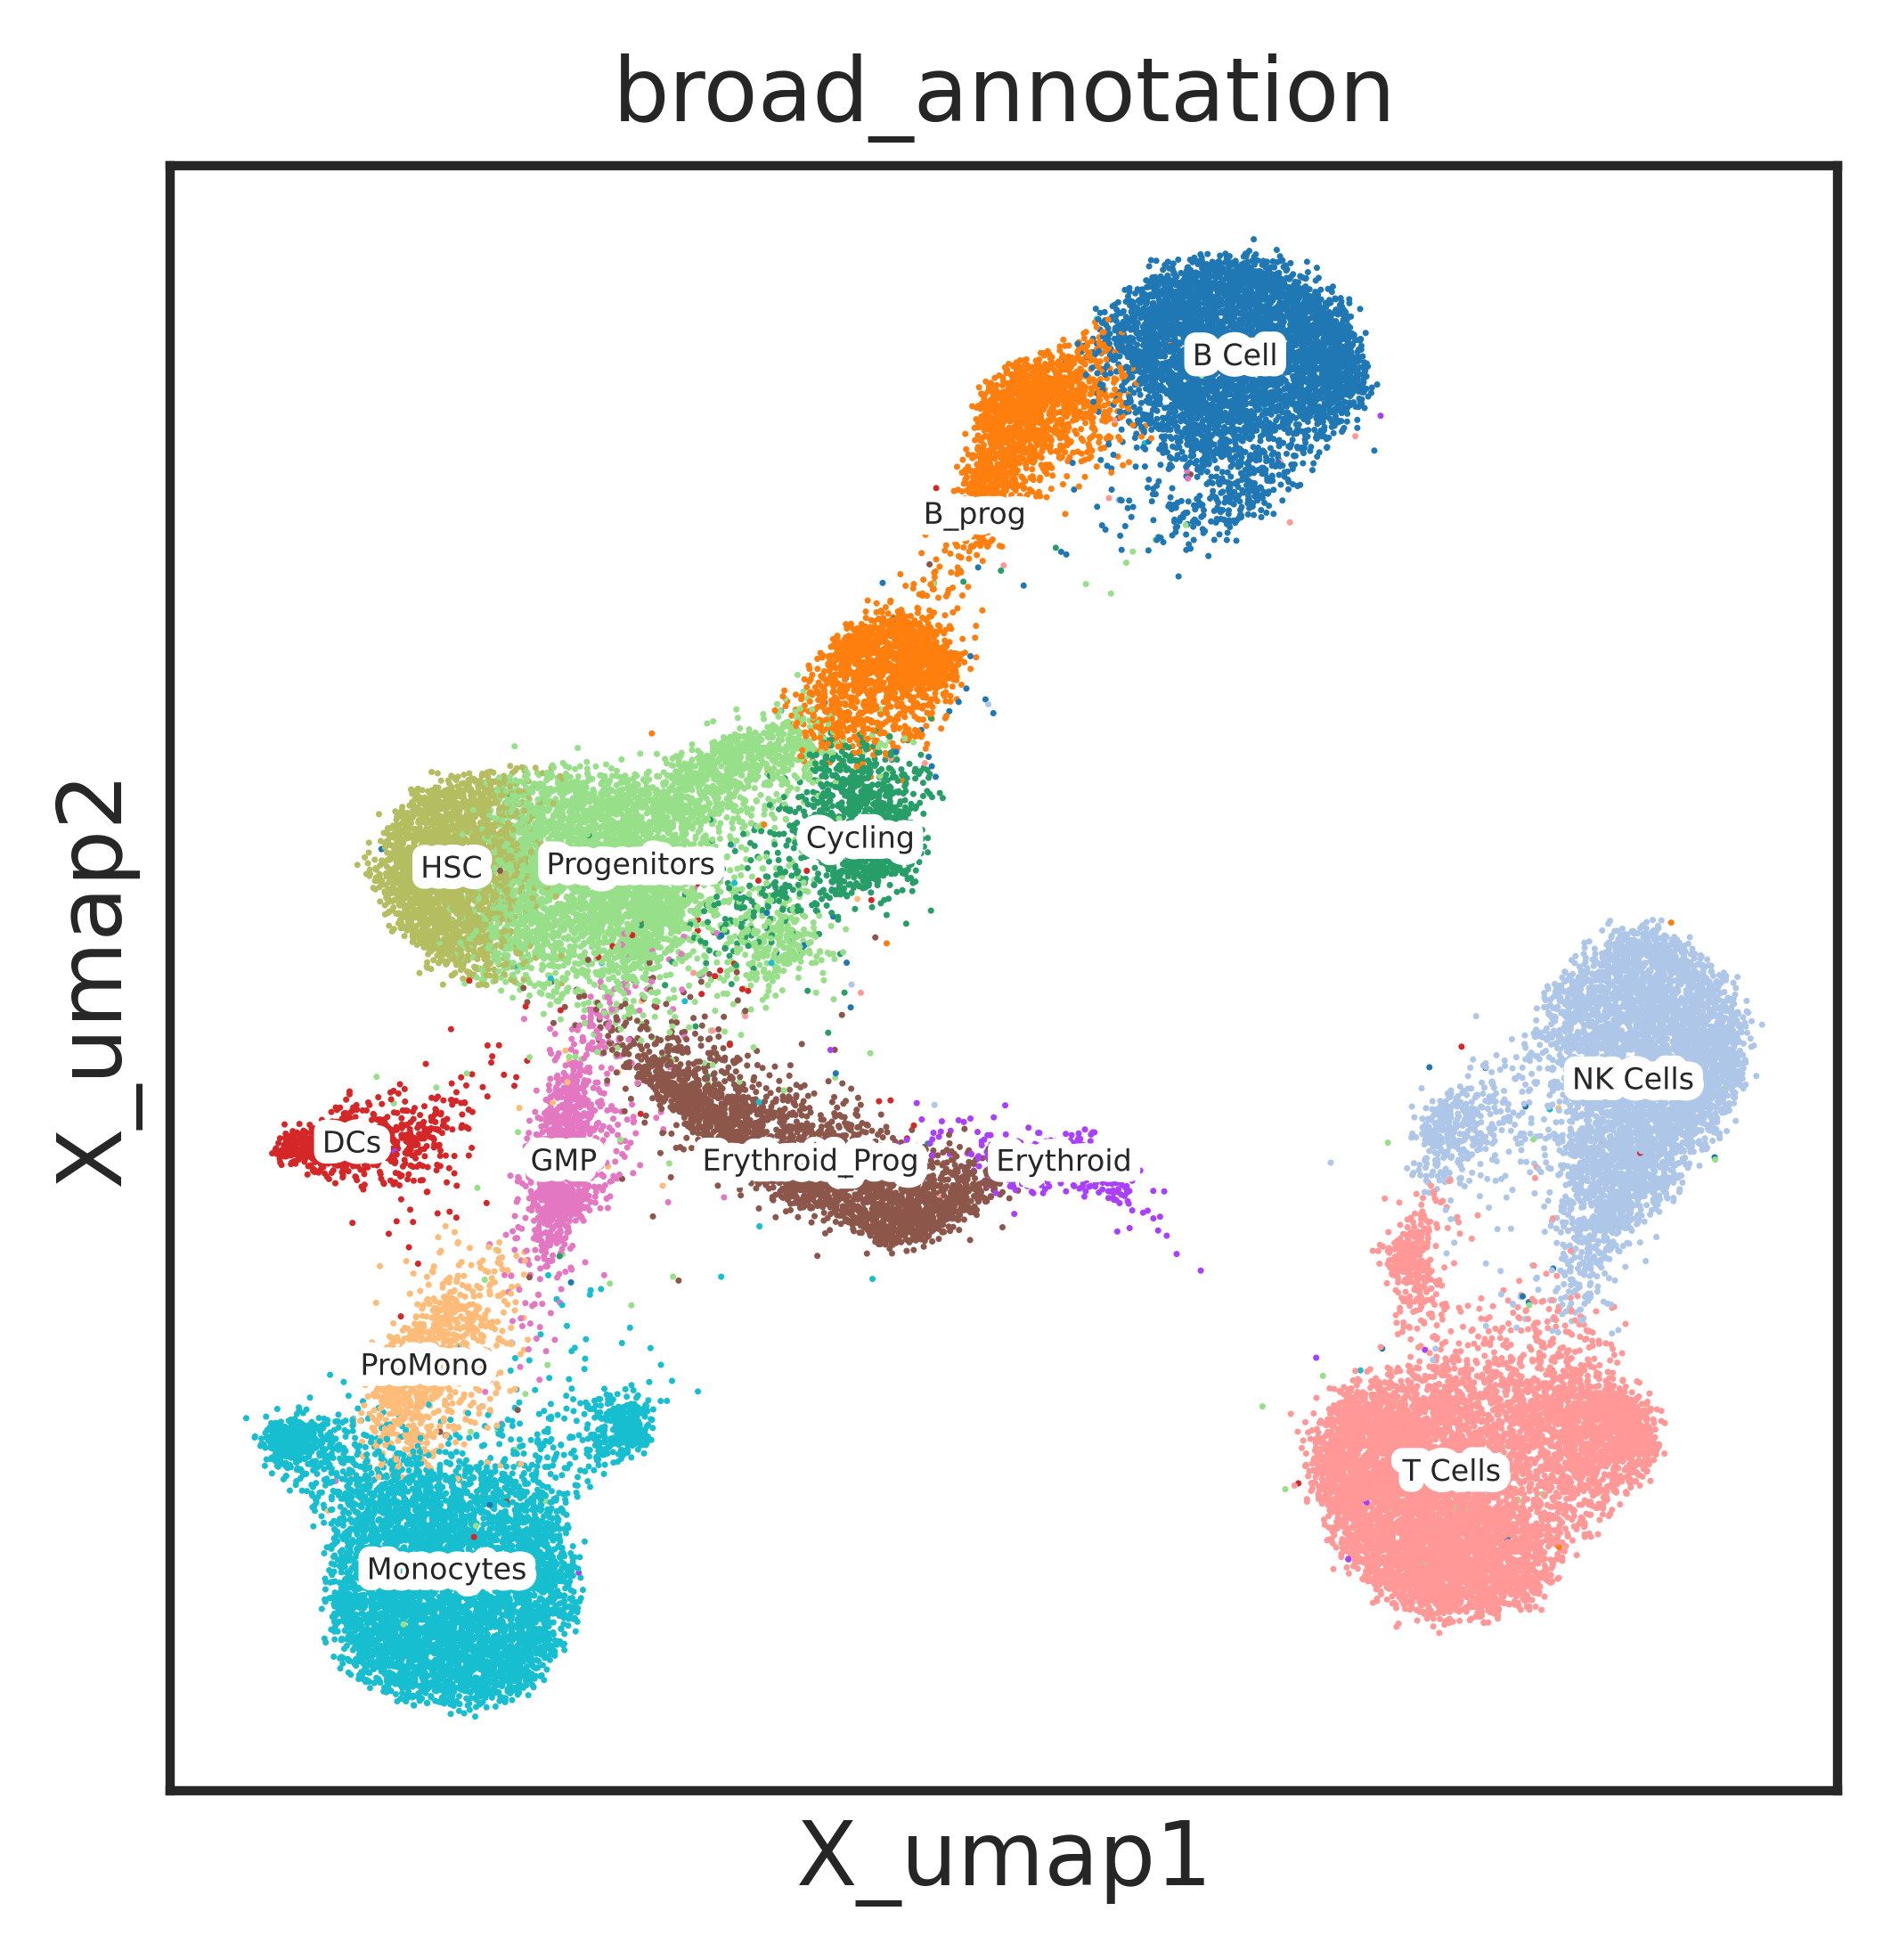

In [8]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(
    adata_ref,
    color=["broad_annotation"],legend_loc = "on data",
    basis="X_umap",
     legend_fontsize = 4,legend_fontweight = "medium", legend_fontoutline = 3, ncols = 1, vmin = "p10", vmax = "p99", color_map = "RdGy_r"
    )

In [9]:
def process_all_samples(AML_all, adata_ref, samples_list, column_to_use = "broad_annotation"):
    """
    Process all samples through Symphony pipeline and create combined metadata
    
    Args:
        AML_all (AnnData): Combined AnnData object with all samples
        adata_ref (AnnData): Reference AnnData object
        samples_list (list): List of samples to process
    
    Returns:
        pd.DataFrame: Combined metadata with UMAP coordinates and annotations
    """
    all_results = []
    
    # Check if samples exist in the data
    available_samples = set(AML_all["rna"].obs["sample"].unique())
    samples_to_process = [s for s in samples_list if s in available_samples]
    
    if len(samples_to_process) != len(samples_list):
        missing = set(samples_list) - available_samples
        print(f"Warning: Some samples not found in data: {missing}")
    
    for sample in samples_to_process:
        print(f"\nProcessing sample: {sample}")
        
        try:
            # Get query data
            query = AML_all["rna"][AML_all["rna"].obs["sample"].isin([sample])].copy()
            
            # Check if sample has cells
            if query.n_obs == 0:
                print(f"Warning: No cells found for sample {sample}")
                continue
                
            # Find shared genes
            query = query[:, query.var_names.isin(adata_ref.var_names)].copy()
            print(f"Using {query.n_vars} shared genes")
            
            # Preprocess
            query.X = query.layers["raw_counts"].copy() 
            sc.pp.normalize_total(query, target_sum=1e5)
            sc.pp.log1p(query)
            
            # Apply Symphony
            print("Mapping coordinates...")
            sp.tl.map_embedding(adata_query=query, adata_ref=adata_ref)
            sp.tl.ingest(adata_query=query, adata_ref=adata_ref)
            sp.tl.transfer_labels_kNN(
                adata_query=query,
                adata_ref=adata_ref,
                ref_labels=[column_to_use])
            
            # Create metadata for this sample
            print("Creating metadata...")
            sample_metadata = pd.DataFrame(index=query.obs.index)
            sample_metadata['sample'] = sample
            sample_metadata['annotation'] = query.obs[column_to_use]
            
            # Safely add cytogenetics if it exists
            if 'cytogenetics' in query.obs.columns:
                sample_metadata['Cytogenetics'] = query.obs['Cytogenetics']
            
            # Add UMAP coordinates
            sample_metadata['UMAP1'] = query.obsm['X_umap'][:, 0]
            sample_metadata['UMAP2'] = query.obsm['X_umap'][:, 1]
            
            all_results.append(sample_metadata)
            print(f"Completed processing {sample}: {len(sample_metadata)} cells")
            
        except Exception as e:
            print(f"Error processing sample {sample}: {str(e)}")
            continue
    
    if not all_results:
        raise ValueError("No samples were successfully processed")
    
    # Combine all results
    combined_metadata = pd.concat(all_results)
    print(f"\nFinal combined metadata: {len(combined_metadata)} cells from {len(all_results)} samples")
    return combined_metadata

In [ ]:
combined_metadata = process_all_samples(AML_all, adata_ref, list(AML_all["rna"].obs["sample"].unique()) )
combined_metadata

In [11]:
combined_metadata

,sample,annotation,UMAP1,UMAP2
TGGTTAGTCGTTTATC-1_AML7,AML7,Erythroid_Prog,5.052667,3.388255
CAAGATCAGTGAATTG-1_AML7,AML7,Progenitors,3.480425,6.207825
CGCGGTAGTGCTCTTC-1_AML7,AML7,HSC,0.121913,8.065010
CTCGAGGGTCAATGTC-1_AML7,AML7,Erythroid,6.005804,3.706336
CATCCACAGCCGATTT-1_AML7,AML7,Erythroid_Prog,2.677445,3.184017
...,...,...,...,...
ACGCAGCAGGTAAACT-1_AML15_Rel,AML15_Rel,DCs,-2.008797,3.398220
TTGCGTCGTCAGATAA-1_AML15_Rel,AML15_Rel,Progenitors,0.518071,5.770010
TTCGGTCGTAAACCTC-1_AML15_Rel,AML15_Rel,Erythroid_Prog,2.380236,4.293420
CAACCTCTCCGTCAAA-1_AML15_Rel,AML15_Rel,Cycling,4.593655,6.995875


In [12]:
AML_all["rna"].obs["preidcted_annotation"] = combined_metadata["annotation"]

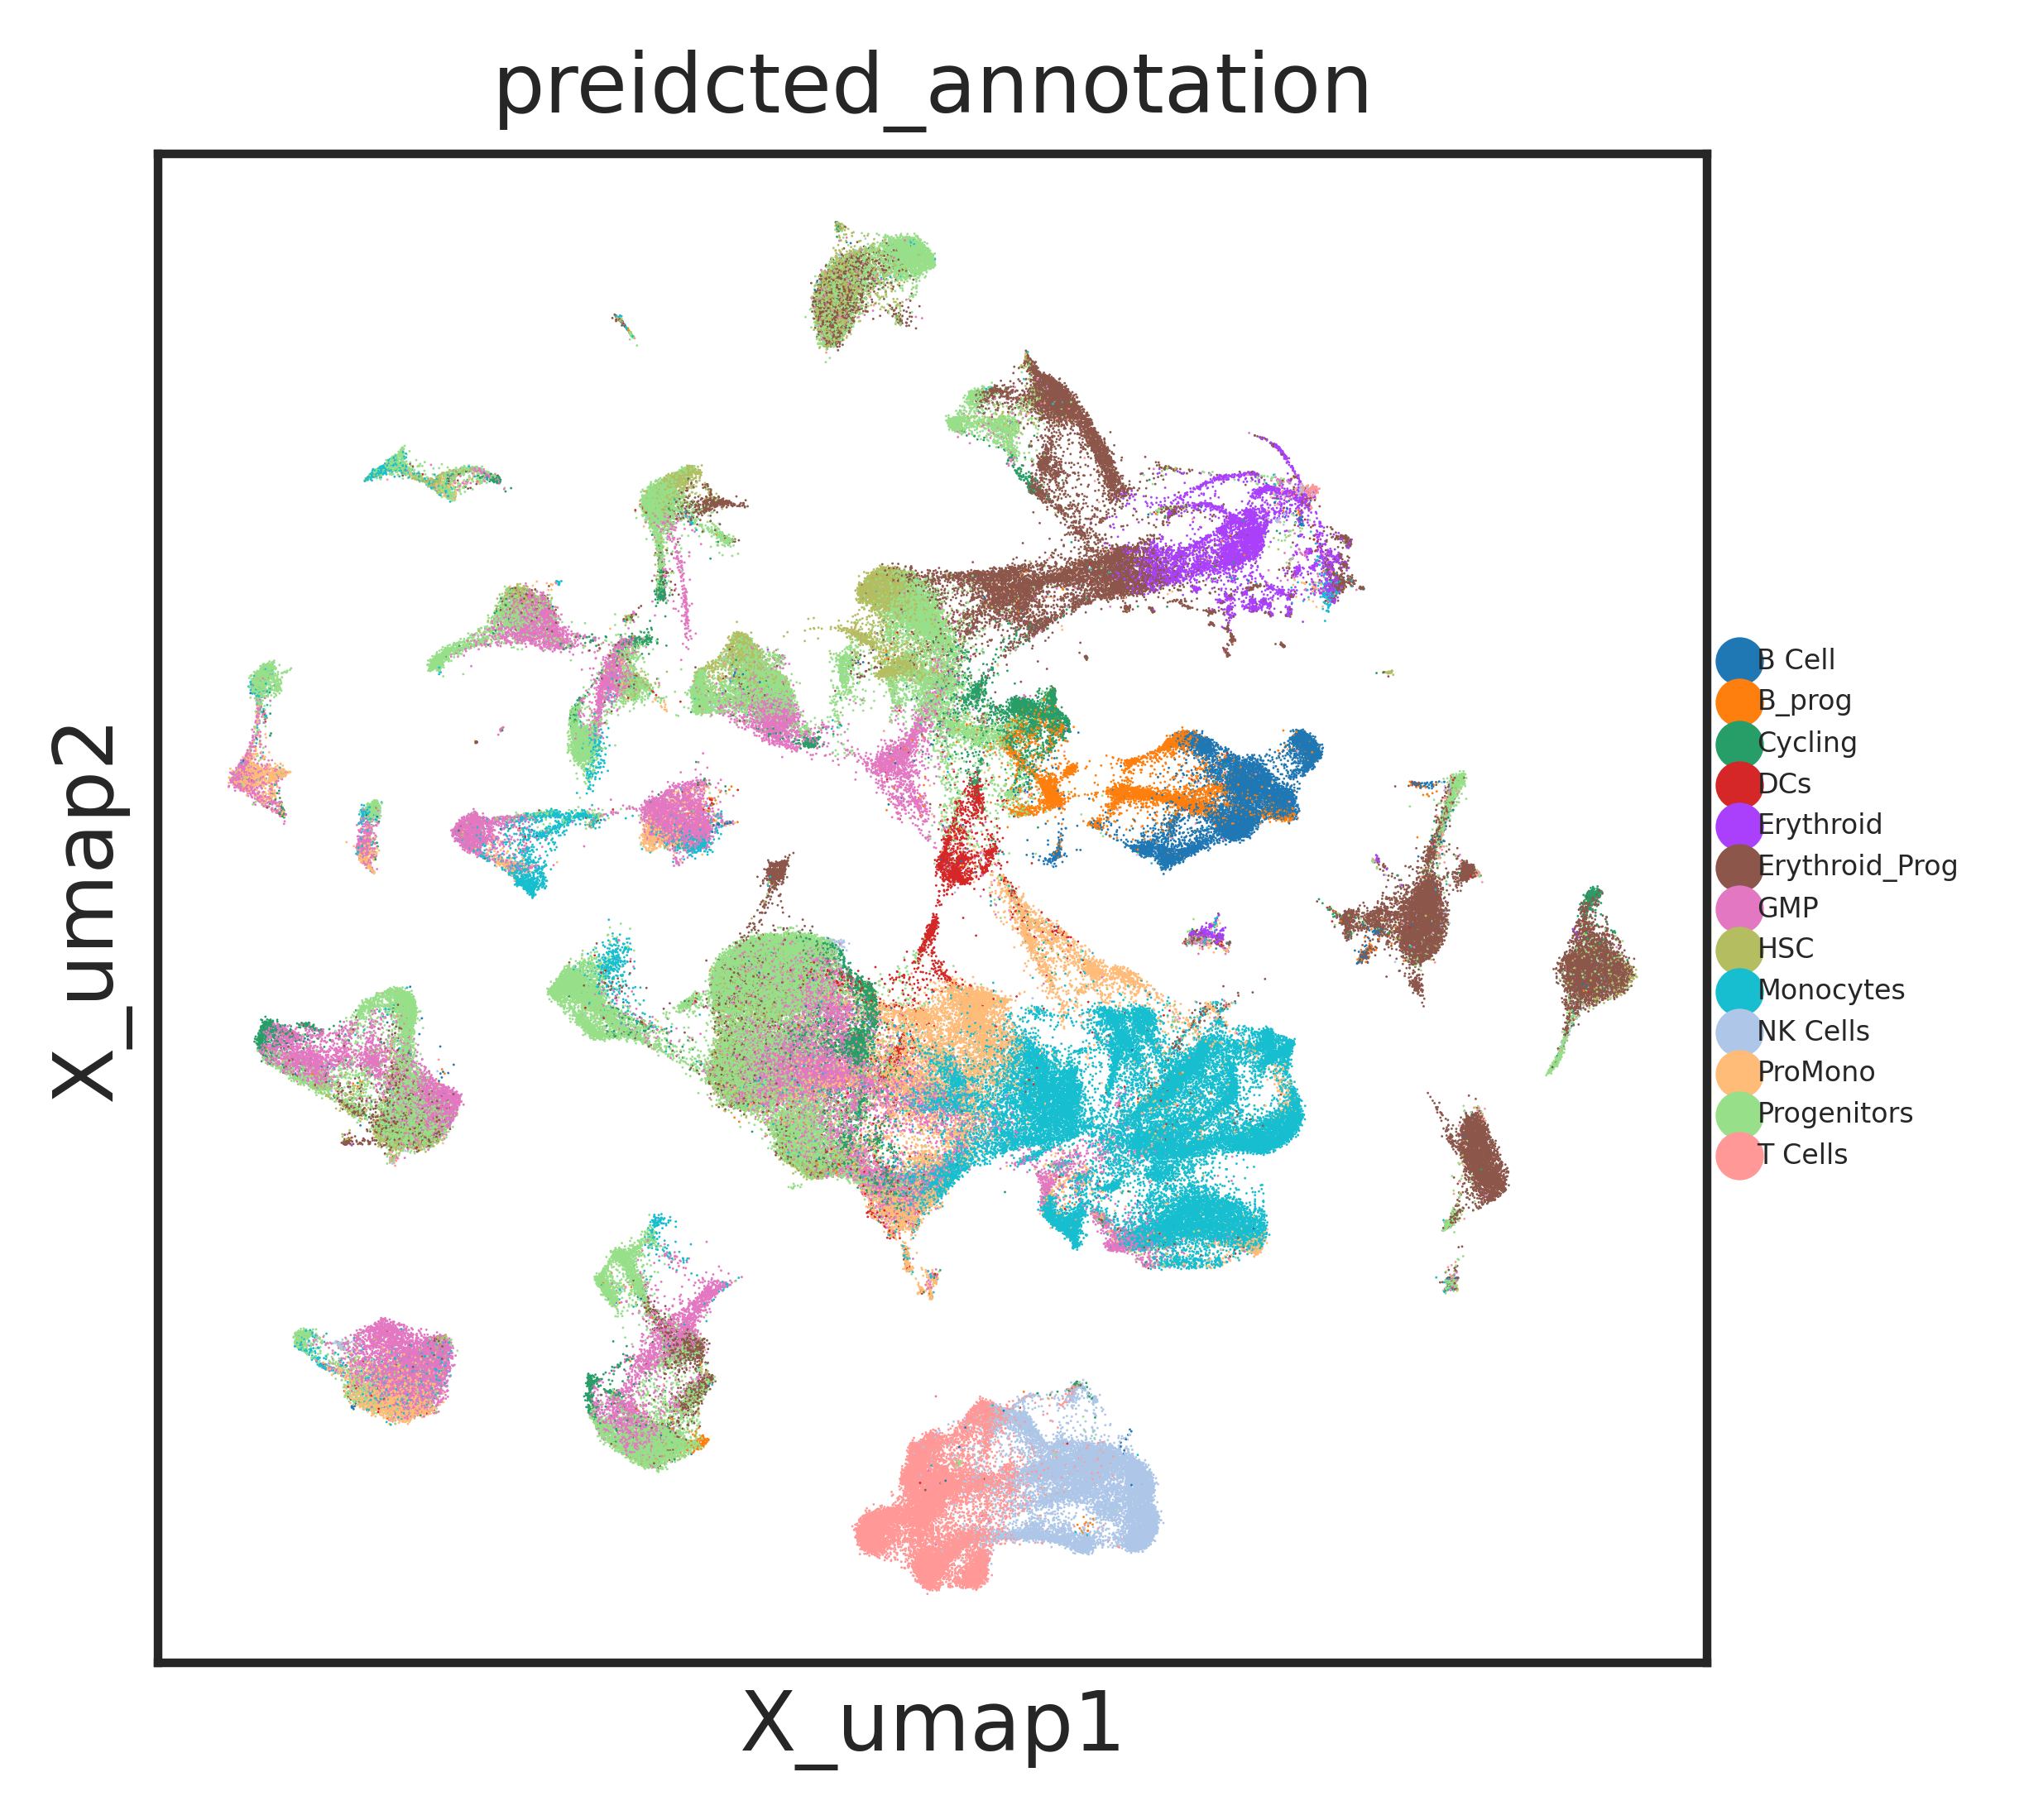

In [13]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(
    AML_all["rna"],
    color=["preidcted_annotation"],
    basis="X_umap",
     legend_fontsize = 4,legend_fontweight = "medium", legend_fontoutline = 3, ncols = 1, vmin = "p10", vmax = "p99", color_map = "RdGy_r"
    )